In [67]:
import numpy as np
import numpy
import jax
from matplotlib import pyplot as plt
import scipy.optimize
import sys
sys.path.append('../STRIDE')
from gfile_helpers import read_gfile, write_gfile, plot_gfile
import time as pytime

In [2]:
colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot
import matplotlib
from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 10
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (6,4)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'small'
rcParams['axes.titlesize'] = 'medium'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'x-small'
rcParams['ytick.labelsize'] = 'x-small'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8

In [3]:
def factorial(n):
    """wrapper for factorial function"""
    
    return numpy.math.factorial(n)

def zern_radial(x,l,m):
    """Zernike radial basis function
    
    Args:
        x (array-like): points to evaluate basis 
        l (int): radial mode number
        m (int): azimuthal mode number
    """
    m = abs(m)
    y = np.zeros_like(x)
    if (l-m)%2 != 0:
        return y
    else:
        for k in range(int((l-m)/2)+1):
            y += (-1)**k* factorial(l-k)/(
                 factorial(k)* factorial((l+m)/2-k)* factorial((l-m)/2-k))*x**(l-2*k)
        return y
    
def zern_radial_r(x,l,m):
    """Zernike radial basis function, first derivative in r
    
    Args:
        x (array-like): points to evaluate basis 
        l (int): radial mode number
        m (int): azimuthal mode number
    """
    m = abs(m)
    y = np.zeros_like(x)
    if (l-m)%2 != 0:
        return y
    else:
        for k in range(int((l-m)/2)+1):
            y += (l-2*k)*(-1)**k* factorial(l-k)/(
                 factorial(k)* factorial((l+m)/2-k)* factorial((l-m)/2-k))*x**max(l-2*k-1,0)
        return y
    
def zern_radial_rr(x,l,m):
    """Zernike radial basis function, second radial derivative
    
    Args:
        x (array-like): points to evaluate basis 
        l (int): radial mode number
        m (int): azimuthal mode number
    """
    y = np.zeros_like(x)
    if (l-m)%2 != 0:
        return y
    else:
        m = abs(m)
        for k in range(int((l-m)/2)+1):
            y += (l-2*k-1)*(l-2*k)*(-1)**k* factorial(l-k)/(
                 factorial(k)* factorial((l+m)/2-k)* factorial((l-m)/2-k))*x**max(l-2*k-2,0)
        return y
    
def zern_azimuthal(theta,l,m):
    """Zernike azimuthal basis function
    
    Args:
        theta (array-like): points to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
    """
    if m<0:
        return np.sin(abs(m)*theta)
    else:
        return np.cos(abs(m)*theta)
    
def zern_azimuthal_v(theta,l,m):
    """Zernike azimuthal basis function, first azimuthal derivative
    
    Args:
        theta (array-like): points to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
    """
    if m<0:
        return m*np.cos(abs(m)*theta)
    else:
        return -m*np.sin(abs(m)*theta)
    
def zern_azimuthal_vv(theta,l,m):
    """Zernike azimuthal basis function, second azimuthal derivative
    
    Args:
        theta (array-like): points to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
    """
    if m<0:
        return -m**2*np.sin(abs(m)*theta)
    else:
        return -m**2*np.cos(abs(m)*theta)
    
def zern(r,theta,l,m,dr=0,dtheta=0):
    """Zernike 2D basis function
    
    Args:
        r (array-like): radial coordinates to evaluate basis
        theta (array-like): azimuthal coordinates to evaluate basis
        l (int): radial mode number
        m (int): azimuthal mode number
        dr (int): order of radial derivative
        dtheta (int): order of azimuthal derivative
    """
    if dr == 0:
        radial = zern_radial(r,l,m)
    elif dr == 1:
        radial = zern_radial_r(r,l,m)
    elif dr == 2:
        radial = zern_radial_rr(r,l,m)
    else:
        raise NotImplementedError
        
    if dtheta == 0:
        azimuthal = zern_azimuthal(theta,l,m)
    elif dtheta == 1:
        azimuthal = zern_azimuthal_v(theta,l,m)
    elif dtheta == 2:
        azimuthal = zern_azimuthal_vv(theta,l,m)
    else:
        raise NotImplementedError
    return radial*azimuthal

def four(zeta,n,NFP,dz=0):
    """Toroidal Fourier basis function
    
    Args:
        zeta (array-like): coordinates to evaluate basis
        n (int): toroidal mode number
        NFP (int): number of field periods
        dz (int): order or toroidal derivative    
    """
    if dz == 0:
        if n<0:
            return np.sin(abs(n)*NFP*zeta)
        else:
            return np.cos(abs(n)*NFP*zeta)
    if dz == 1:
        if n<0:
            return n*NFP*np.cos(abs(n)*NFP*zeta)
        else:
            return -n*NFP*np.sin(abs(n)*NFP*zeta)
    if dz == 2:
        if n<0:
            return -(n*NFP)**2*np.sin(abs(n)*NFP*zeta)
        else:
            return -(n*NFP)**2*np.cos(abs(n)*NFP*zeta)
        
def F_mn(theta,phi,m,n,NFP):
    """Double Fourier series for boundary/lambda
    
    Args:
        theta (array-like): poloidal angle to evaluate basis
        phi (array-like): toroidal angle to evaluate bais
        m (int): poloidal mode number
        n (int): toroidal mode number
        NFP (int): number of field periods
    """
    if m>=0 and n>=0:
        return np.cos(abs(m)*theta)*np.cos(abs(n)*NFP*phi)
    if m>=0 and n<0:
        return np.cos(abs(m)*theta)*np.sin(abs(n)*NFP*phi)
    if m<0 and n>=0:
        return np.sin(abs(m)*theta)*np.cos(abs(n)*NFP*phi)
    if m<0 and n<0:
        return np.sin(abs(m)*theta)*np.sin(abs(n)*NFP*phi)
        
def fourzern(r,theta,zeta,l,m,n,NFP,dr=0,dv=0,dz=0):
    """Combined 3D Fourier-Zernike basis function
    
    Args:
        r (array-like): radial coordinates
        theta (array-like): poloidal coordinates
        zeta (array-like): toroidal coordinates
        l (int): radial mode number
        m (int): poloidal mode number
        n (int): toroidal mode number
        NFP (int): number of field periods
        dr (int): order of radial derivative
        dv (int): order of poloidal derivative
        dz (int): order of toroidal derivative
    """
    return zern(r,theta,l,m,dr,dv)*four(zeta,n,NFP,dz)

In [96]:
def zernike_norm(l, m):
    """Norm of a Zernike polynomial with l, m indexing."""
    return np.sqrt((2 * (l + 1)) / (1 + np.kronecker(m, 0)))

def lm_to_fringe(l, m):
    """Convert (l,m) two term index to Fringe index."""
    term1 = (1 + (l + np.abs(m))/2)**2
    term2 = 2 * np.abs(m)
    term3 = (1 + np.sign(m)) / 2
    return int(term1 - term2 - term3)  

def fringe_to_lm(idx):
    """Convert Fringe Z to (l, m) two-term index."""
    idx += 1 # shift 0 base to 1 base
    m_l = 2 * (np.ceil(np.sqrt(idx)) - 1)  # sum of n+m
    g_s = (m_l / 2)**2 + 1  # start of each group of equal n+m given as idx index
    l = m_l / 2 + np.floor((idx - g_s) / 2)
    m = (m_l - l) * (1 - np.mod(idx-g_s, 2) * 2)
    return int(l), int(m)

def dot(a,b,axis=-1):
    """wrapper for vector dot product"""
    return np.sum(a*b,axis=axis,keepdims=False)

def cross(a,b,axis=-1):
    """wrapper for vector cross product with some error handling"""
    if a.size and b.size:
        return np.cross(a,b,axis=axis)
    else:
        return np.array([])
    
def rms(x):
    """Compute rms value of an array"""
    return np.sqrt(np.mean(x**2))
    
def iotafun(rho,nu=0, params=None):
    """Rotational transform
    
    Args:
        rho (array-like): coordinates at which to evaluate
        nu (int): order of derivative (for compatibility with scipy spline routines)
    """
    if nu==0:
        return .7*(1-rho**2)
    elif nu==1:
        return -.7*2*rho
    else:
        raise NotImplementedError
        
def pressfun(rho,nu=0, params=None):
    """Plasma pressure * mu0
    
    Args:
        rho (array-like): coordinates at which to evaluate
        nu (int): order of derivative (for compatibility with scipy spline routines)
    """
    mu0 = 4*np.pi*1e-7
    p0 = 1e4
    if nu==0:
        return mu0*p0*(1-rho**2)
    elif nu==1:
        return  -mu0*p0*2*rho
    else:
        raise NotImplementedError

In [181]:
def get_initial_guess_scale_bdry(bdryR,bdryZ,bdry_theta,bdry_phi,M,N,NFP,nr=20,rcond=1e-1, return_rvz=False):
    """Generate initial guess by scaling boundary shape
    
    Args:
        bdryR (array-like): R coordinates of boundary
        bdryZ (array-like): Z coordinates of boundary
        bdry_theta (array-like): poloidal coordinates where bdryR,bdryZ are given
        bdry_phi (array-like): toroidal coordinates where bdryR,bdryZ are given
        M (int): maximum poloidal mode number
        N (int): maximum toroidal mode number
        NFP (int): number of field periods
        nr (int): number of radial points to use when generating guess
        rcond (float): relative limit on singular values for least squares fit to Zernike basis
        return_rvz (bool): whether to also return the grid used to generate the initial guess
        
    Returns:
        cR (array-like): Fourier-Zernike coefficients for R, indexed as (lm,n) flattened in row major order
        cZ (array-like): Fourier-Zernike coefficients for Z, indexed as (lm,n) flattened in row major order
        cL (array-like): double Fourier series coefficients for lambda, indexed as (m,n) flattened in row major order
        Rinit (array-like): R coordinates of initial flux surface guess
        Zinit (array-like): Z coordinates of initial flux surface guess
        
        if return_rvz:
        rr,vv,zz (array-like): grid used to generate initial guess
    """
    
    
    r = np.linspace(1e-2,1,nr)
    rr,tt = np.meshgrid(r,bdry_theta,indexing='ij')
    rr,pp = np.meshgrid(r,bdry_phi,indexing='ij')
    rr = rr.flatten()
    tt = tt.flatten()
    pp = pp.flatten()
    vv = np.pi - tt
    zz = -pp

    zernt = ZernikeTransform([rr,vv,zz],M,N,NFP)
    R0_est = (np.max(bdryR) + np.min(bdryR))/2
    Z0_est = (np.max(bdryZ) + np.min(bdryZ))/2

    Rinit = (r[:,np.newaxis]*(bdryR[np.newaxis,:]-R0_est) + R0_est).flatten()
    Zinit = (r[:,np.newaxis]*(bdryZ[np.newaxis,:]-Z0_est) + Z0_est).flatten()

    cL = np.zeros((2*M+1)*(2*N+1))
    cR = zernt.fit(Rinit,rcond=rcond).flatten()
    cZ = zernt.fit(Zinit,rcond=rcond).flatten()
    if return_rvz:
        return cR, cZ, cL, Rinit, Zinit, rr, vv, zz
    else:
        return cR, cZ, cL, Rinit, Zinit

In [6]:
class ZernikeTransform():
    """Zernike Transform (really a Fourier-Zernike, but whatever)
    
    Args:
        nodes (array-like): nodes where basis functions are evaluated
        M (int): maximum poloidal mode number
        N (int): maximum toroidal mode number
        NFP (int): number of field periods    
    """
    def __init__(self,nodes, M,N,NFP):
        num_lm_modes = (M+1)**2
        num_four = 2*N+1
        # array of which l,m,n is at which column of the interpolation matrix
        self.idx = np.array([(*fringe_to_lm(i),n) for i in range(num_lm_modes) for n in range(num_four)])
        # array of which r,v,z is at which row of the interpolation matrix
        self.nodes = nodes
        self.M = M
        self.N = N
        self.NFP = NFP
        self.matrices = {i:{j:{k:np.stack([fourzern(nodes[0],nodes[1],nodes[2],
                                               *fringe_to_lm(lm),n-N,NFP,dr=i,dv=j,dz=k) 
                                           for lm in range(num_lm_modes) for n in range(num_four)]).T 
                                           for k in range(3)} for j in range(3)} for i in range(3)}
    def transform(self,c,dr=0,dv=0,dz=0):
        """Transform from spectral domain to physical
        
        Args:
            c (array-like): spectral coefficients, indexed as (lm,n) flattened in row major order
            dr (int): order of radial derivative
            dv (int): order of poloidal derivative
            dz (int): order of toroidal derivative
        """
        return np.matmul(self.matrices[dr][dv][dz],c)
    
    def fit(self,x,rcond=1e-1):
        """Transform from physical domain to spectral
        
        Args:
            x (array-like): values in real space at coordinates specified by self.nodes
            rcond (float): relative cutoff for singular values in least squares fit        
        """
        return np.linalg.lstsq(self.matrices[0][0][0],x,rcond=rcond)[0]
        

In [180]:
def bc_err_RZ(cR,cZ,cL,bdryR,bdryZ,bdry_theta,bdry_phi,M,N,NFP):
    """Compute boundary error at discrete points
    
    Args:
        cR (array-like): Fourier-Zernike coefficients of R
        cZ (array-like): Fourier-Zernike coefficients of Z
        cL (array-like): double Fourier coefficients of lambda
        bdryR (array-like): R values of boundary shape
        bdryZ (array-like): Z values of boundary shape
        bdry_theta (array-like): real space poloidal coordinates where boundary is specified
        bdry_phi (array-like): real space toroidal coordinates where boundary is specified
        M (int): maximum poloidal mode number
        N (int): maximum toroidal mode number
        NFP (int): number of field periods   
        
    Returns:
        errR (array-like): vector of R errors in boundary position at specified points
        errZ (array-like): vector of Z errors in boundary position at specified points
        errL (float): sum of lambda_mn
    """
    num_lm_modes = (M+1)**2
    num_four = 2*N+1    
    # compute lambda, theres probably a faster vectorized way to do this
    cL = cL.reshape((2*M+1,2*N+1))
    L = np.zeros_like(bdry_theta)
    for i in range(cL.shape[0]):
        for j in range(cL.shape[1]):
            m = -M + i
            n = -N + j
            L += cL[i,j]*F_mn(bdry_theta,bdry_phi,m,n,NFP)

    # find values of R,Z at pts specified
    vartheta = np.pi - bdry_theta + L
    zeta = -bdry_phi
    bdry_interp = np.stack([fourzern(np.ones_like(bdry_theta),vartheta,zeta,*fringe_to_lm(i),n-N,NFP) for i in range(num_lm_modes) 
                            for n in range(num_four)]).T
    R = np.matmul(bdry_interp,cR).flatten()
    Z = np.matmul(bdry_interp,cZ).flatten()

    # compute errors
    errR = R-bdryR
    errZ = Z-bdryZ
    errL = np.sum(cL[M:,N:])
    return errR,errZ,errL

In [8]:
def compute_coordinate_derivatives(cR,cZ,zernt):
    """Converts from spectral to real space and evaluates derivatives of R,Z wrt to SFL coords
    
    Args:
        cR (array-like): spectral coefficients of R
        cZ (array-like): spectral coefficients of Z
        zernt (ZernikeTransform): object with transform method to go from spectral to physical space with derivatives
    
    Returns:
        coordinate_derivatives (dict): dictionary of arrays of coordinate derivatives evaluated at node locations
    """
    
    # notation: X_y means derivative of X wrt y
    coordinate_derivatives = {}
    coordinate_derivatives['R'] = zernt.transform(cR)
    coordinate_derivatives['Z'] = zernt.transform(cZ)
    coordinate_derivatives['0'] = np.zeros_like(coordinate_derivatives['R'])
    
    coordinate_derivatives['R_r'] = zernt.transform(cR,dr=1)
    coordinate_derivatives['Z_r'] = zernt.transform(cZ,dr=1)
    coordinate_derivatives['R_v'] = zernt.transform(cR,dv=1)
    coordinate_derivatives['Z_v'] = zernt.transform(cZ,dv=1)
    coordinate_derivatives['R_z'] = zernt.transform(cR,dz=1)
    coordinate_derivatives['Z_z'] = zernt.transform(cZ,dz=1)

    coordinate_derivatives['R_rr'] = zernt.transform(cR,dr=2)
    coordinate_derivatives['Z_rr'] = zernt.transform(cZ,dr=2)
    coordinate_derivatives['R_rv'] = zernt.transform(cR,dr=1,dv=1)
    coordinate_derivatives['Z_rv'] = zernt.transform(cZ,dr=1,dv=1)
    coordinate_derivatives['R_rz'] = zernt.transform(cR,dr=1,dz=1)
    coordinate_derivatives['Z_rz'] = zernt.transform(cZ,dr=1,dz=1)

    coordinate_derivatives['R_vr'] = zernt.transform(cR,dr=1,dv=1)
    coordinate_derivatives['Z_vr'] = zernt.transform(cZ,dr=1,dv=1)
    coordinate_derivatives['R_vv'] = zernt.transform(cR,dv=2)
    coordinate_derivatives['Z_vv'] = zernt.transform(cZ,dv=2)
    coordinate_derivatives['R_vz'] = zernt.transform(cR,dv=1,dz=1)
    coordinate_derivatives['Z_vz'] = zernt.transform(cZ,dv=1,dz=1)

    coordinate_derivatives['R_zr'] = zernt.transform(cR,dr=1,dz=1)
    coordinate_derivatives['Z_zr'] = zernt.transform(cZ,dr=1,dz=1)
    coordinate_derivatives['R_zv'] = zernt.transform(cR,dv=1,dz=1)
    coordinate_derivatives['Z_zv'] = zernt.transform(cZ,dv=1,dz=1)
    coordinate_derivatives['R_zz'] = zernt.transform(cR,dz=2)
    coordinate_derivatives['Z_zz'] = zernt.transform(cZ,dz=2)

    coordinate_derivatives['R_rrv'] = zernt.transform(cR,dr=2,dv=1)
    coordinate_derivatives['Z_rrv'] = zernt.transform(cZ,dr=2,dv=1)
    coordinate_derivatives['R_rvv'] = zernt.transform(cR,dr=1,dv=2)
    coordinate_derivatives['Z_rvv'] = zernt.transform(cZ,dr=1,dv=2)
    coordinate_derivatives['R_zrv'] = zernt.transform(cR,dr=1,dv=1,dz=1)
    coordinate_derivatives['Z_zrv'] = zernt.transform(cZ,dr=1,dv=1,dz=1)

    coordinate_derivatives['R_rrvv'] = zernt.transform(cR,dr=2,dv=2)
    coordinate_derivatives['Z_rrvv'] = zernt.transform(cZ,dr=2,dv=2)
    
    return coordinate_derivatives

In [9]:
def compute_covariant_basis_vectors(coordinate_derivatives):
    """Computes covariant basis vectors at grid points
    
    Args:
        coordinate_derivatives (dict): dictionary of arrays of the coordinate derivatives at each node
        
    Returns:
        covariant_basis (dict): dictionary of arrays of covariant basis vectors and derivatives at each node
    """
    # notation: first subscript is direction of unit vector, others denote partial derivatives
    # eg, e_rv is the v derivative of the covariant basis vector in the r direction
    cov_basis = {}
    cov_basis['e_r'] = np.array([coordinate_derivatives['R_r'],coordinate_derivatives['0'],coordinate_derivatives['Z_r']])
    cov_basis['e_v'] = np.array([coordinate_derivatives['R_v'],coordinate_derivatives['0'],coordinate_derivatives['Z_v']])
    cov_basis['e_z'] = np.array([coordinate_derivatives['R_z'],coordinate_derivatives['R'],coordinate_derivatives['Z_z']])

    cov_basis['e_rr'] = np.array([coordinate_derivatives['R_rr'],coordinate_derivatives['0'],coordinate_derivatives['Z_rr']])
    cov_basis['e_rv'] = np.array([coordinate_derivatives['R_rv'],coordinate_derivatives['0'],coordinate_derivatives['Z_rv']])
    cov_basis['e_rz'] = np.array([coordinate_derivatives['R_rz'],coordinate_derivatives['0'],coordinate_derivatives['Z_rz']])

    cov_basis['e_vr'] = np.array([coordinate_derivatives['R_vr'],coordinate_derivatives['0'],coordinate_derivatives['Z_vr']])
    cov_basis['e_vv'] = np.array([coordinate_derivatives['R_vv'],coordinate_derivatives['0'],coordinate_derivatives['Z_vv']])
    cov_basis['e_vz'] = np.array([coordinate_derivatives['R_vz'],coordinate_derivatives['0'],coordinate_derivatives['Z_vz']])

    cov_basis['e_zr'] = np.array([coordinate_derivatives['R_zr'],coordinate_derivatives['R_r'],coordinate_derivatives['Z_zr']])
    cov_basis['e_zv'] = np.array([coordinate_derivatives['R_zv'],coordinate_derivatives['R_v'],coordinate_derivatives['Z_zv']])
    cov_basis['e_zz'] = np.array([coordinate_derivatives['R_zz'],coordinate_derivatives['R_z'],coordinate_derivatives['Z_zz']])

    cov_basis['e_rvv'] = np.array([coordinate_derivatives['R_rvv'],coordinate_derivatives['0'],coordinate_derivatives['Z_rvv']])
    cov_basis['e_rvz'] = np.array([coordinate_derivatives['R_zrv'],coordinate_derivatives['0'],coordinate_derivatives['Z_zrv']])
    cov_basis['e_zrv'] = np.array([coordinate_derivatives['R_zrv'],-coordinate_derivatives['R_rv'],coordinate_derivatives['Z_zrv']])
    
    return cov_basis

In [10]:
def compute_jacobian(coordinate_derivatives,covariant_basis_vectors):
    """Computes coordinate jacobian and derivatives
    
    Args:
        coordinate_derivatives (dict): dictionary of arrays of coordinate derivatives evaluated at node locations
        covariant_basis_vectors (dict): dictionary of arrays of covariant basis vectors and derivatives at each node 
        
    Returns:
        jacobian (dict): dictionary of arrays of coordinate jacobian and partial derivatives
    """
    # notation: subscripts denote partial derivatives
    jacobian = {}    
    jacobian['g'] = dot(covariant_basis_vectors['e_r'] , cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_z'],0),0)

    jacobian['g_r'] = dot(covariant_basis_vectors['e_rr'],cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_z'],0),0) \
                      + dot(covariant_basis_vectors['e_r'],cross(covariant_basis_vectors['e_rv'],covariant_basis_vectors['e_z'],0),0) \
                      + dot(covariant_basis_vectors['e_r'],cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_zr'],0),0)
    jacobian['g_v'] = dot(covariant_basis_vectors['e_rv'],cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_z'],0),0) \
                      + dot(covariant_basis_vectors['e_r'],cross(covariant_basis_vectors['e_vv'],covariant_basis_vectors['e_z'],0),0) \
                      + dot(covariant_basis_vectors['e_r'],cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_zv'],0),0)
    jacobian['g_z'] = dot(covariant_basis_vectors['e_rz'],cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_z'],0),0) \
                      + dot(covariant_basis_vectors['e_r'],cross(covariant_basis_vectors['e_vz'],covariant_basis_vectors['e_z'],0),0) \
                      + dot(covariant_basis_vectors['e_r'],cross(covariant_basis_vectors['e_v'],covariant_basis_vectors['e_zz'],0),0)
    jacobian['g_rr']  = coordinate_derivatives['R']*(coordinate_derivatives['R_r']*coordinate_derivatives['Z_rrv'] 
                                                     - coordinate_derivatives['Z_r']*coordinate_derivatives['R_rrv']
                                                     + 2*coordinate_derivatives['R_rr']*coordinate_derivatives['Z_rv']
                                                     - 2*coordinate_derivatives['R_rv']*coordinate_derivatives['Z_rr']) \
                                        + 2*coordinate_derivatives['R_r']*(coordinate_derivatives['Z_rv']*coordinate_derivatives['R_r']
                                                                           - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_r'])
    jacobian['g_rv']  = coordinate_derivatives['R']*(coordinate_derivatives['Z_rvv']*coordinate_derivatives['R_r']
                                                     - coordinate_derivatives['R_rvv']*coordinate_derivatives['Z_r'])
    jacobian['g_zr']  = coordinate_derivatives['R_z']*(coordinate_derivatives['R_r']*coordinate_derivatives['Z_rv'] 
                                                       - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_r']) \
                            + coordinate_derivatives['R']*(coordinate_derivatives['R_zr']*coordinate_derivatives['Z_rv'] 
                                                           + coordinate_derivatives['R_r']*coordinate_derivatives['Z_zrv']
                                                           - coordinate_derivatives['R_zrv']*coordinate_derivatives['Z_r']
                                                           - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_zr'])
    jacobian['g_rrv'] = 2*coordinate_derivatives['R_rv']*(coordinate_derivatives['Z_rv']*coordinate_derivatives['R_r']
                                                          - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_r']) \
                            + 2*coordinate_derivatives['R_r']*(coordinate_derivatives['Z_rvv']*coordinate_derivatives['R_r']
                                                               - coordinate_derivatives['R_rvv']*coordinate_derivatives['Z_r']) \
                            + coordinate_derivatives['R']*(coordinate_derivatives['R_r']*coordinate_derivatives['Z_rrvv']
                                                           - coordinate_derivatives['Z_r']*coordinate_derivatives['R_rrvv']
                                                           + 2*coordinate_derivatives['R_rr']*coordinate_derivatives['Z_rvv']
                                                           - coordinate_derivatives['R_rv']*coordinate_derivatives['Z_rrv']
                                                           - 2*coordinate_derivatives['Z_rr']*coordinate_derivatives['R_rvv']
                                                           + coordinate_derivatives['Z_rv']*coordinate_derivatives['R_rrv'])
    for key, val in jacobian.items():
        jacobian[key] = val.flatten()
    
    return jacobian

In [95]:
def compute_B_field(Psi_total, jacobian, nodes, covariant_basis_vectors, iotafun):
    """Computes magnetic field at node locations
    
    Args:
        Psi_total (float): total toroidal flux within LCFS
        jacobian (dict): dictionary of arrays of coordinate jacobian and partial derivatives
        nodes (array-like): array of node locations in rho, vartheta, zeta coordinates
        covariant_basis_vectors (dict): dictionary of arrays of covariant basis vectors and derivatives at each node 
        iotafun (callable): rotational transform = iotafun(x,nu). First argument, x, is points to evaluate rotational transform at. 
            Second argument, nu, is the order of derivative to evaluate.
    
    Return:
        B_field (dict): dictionary of values of magnetic field and derivatives
    """
    # notation: 1 letter subscripts denote derivatives, eg psi_rr = d^2 psi/dr^2
    # word sub or superscripts denote co and contravariant components of the field
    N_nodes = nodes[0].size
    r = nodes[0]   
    axn = np.where(r == 0)[0];

    iota = iotafun(r,nu=0)
    iotar = iotafun(r,nu=1)
    B_field = {}
    # B field
    B_field['psi'] = Psi_total*r**2 # could instead make Psi(r) an arbitrary function?
    B_field['psi_r']  = 2*Psi_total*r
    B_field['psi_rr'] = 2*Psi_total*np.ones_like(r)
    B_field['B^zeta'] = B_field['psi_r'] / (2*np.pi*jacobian['g'])
    B_field['B^theta'] = iota * B_field['B^zeta']

    # B^{zeta} derivatives
    B_field['B^zeta_r'] = B_field['psi_rr'] / (2*np.pi*jacobian['g']) - (B_field['psi_r']*jacobian['g_r']) / (2*np.pi*jacobian['g']**2)
    B_field['B^zeta_v'] = - (B_field['psi_r']*jacobian['g_v']) / (2*np.pi*jacobian['g']**2)
    B_field['B^zeta_z'] = - (B_field['psi_r']*jacobian['g_z']) / (2*np.pi*jacobian['g']**2)
    # rho=0 terms only
    B_field['B^zeta_rv'] = B_field['psi_rr']*(2*jacobian['g_rr']*jacobian['g_rv'] 
                                              - jacobian['g_r']*jacobian['g_rrv']) / (4*np.pi*jacobian['g_r']**3)

    # magnetic axis
    if axn.size:
        B_field['B^zeta'][axn]  = Psi_total / (np.pi*jacobian['g_r'][axn])
        B_field['B^theta'][axn]  = Psi_total*iota[axn] / (np.pi*jacobian['g_r'][axn])
        B_field['B^zeta_r'][axn] = - (B_field['psi_rr'][axn]*jacobian['g_rr'][axn]) / (4*np.pi*jacobian['g_r'][axn]**2)
        B_field['B^zeta_v'][axn] = 0
        B_field['B^zeta_z'][axn] = - (B_field['psi_rr'][axn]*jacobian['g_zr'][axn]) / (2*np.pi*jacobian['g_r'][axn]**2)

    # covariant B-component derivatives
    B_field['B_theta_r'] = B_field['B^zeta_r']*dot(iota*covariant_basis_vectors['e_v']
                                                   +covariant_basis_vectors['e_z'],covariant_basis_vectors['e_v'],0) \
                            + B_field['B^zeta']*dot(iotar*covariant_basis_vectors['e_v']+iota*covariant_basis_vectors['e_rv']
                                                    +covariant_basis_vectors['e_zr'],covariant_basis_vectors['e_v'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                    covariant_basis_vectors['e_rv'],0)
    B_field['B_zeta_r'] = B_field['B^zeta_r']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                  covariant_basis_vectors['e_z'],0) \
                            + B_field['B^zeta']*dot(iotar*covariant_basis_vectors['e_v']+iota*covariant_basis_vectors['e_rv']
                                                    +covariant_basis_vectors['e_zr'],covariant_basis_vectors['e_z'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                    covariant_basis_vectors['e_zr'],0)
    B_field['B_rho_v'] = B_field['B^zeta_v']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                 covariant_basis_vectors['e_r'],0) \
                        + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_vv']+covariant_basis_vectors['e_zv'],
                                                covariant_basis_vectors['e_r'],0) \
                        + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                covariant_basis_vectors['e_rv'],0)
    B_field['B_zeta_v'] = B_field['B^zeta_v']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                  covariant_basis_vectors['e_z'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_vv']+covariant_basis_vectors['e_zv'],
                                                    covariant_basis_vectors['e_z'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                    covariant_basis_vectors['e_zv'],0)
    B_field['B_rho_z'] = B_field['B^zeta_z']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                 covariant_basis_vectors['e_r'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_vz']+covariant_basis_vectors['e_zz'],
                                                    covariant_basis_vectors['e_r'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                    covariant_basis_vectors['e_rz'],0)
    B_field['B_theta_z'] = B_field['B^zeta_z']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                   covariant_basis_vectors['e_v'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_vz']+covariant_basis_vectors['e_zz'],
                                                    covariant_basis_vectors['e_v'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_v']+covariant_basis_vectors['e_z'],
                                                    covariant_basis_vectors['e_vz'],0)
    # need these later to evaluate axis terms
    B_field['B_zeta_rv'] = B_field['B^zeta_rv']*dot(covariant_basis_vectors['e_z'],covariant_basis_vectors['e_z'],0) \
                            + B_field['B^zeta']*dot(iota*covariant_basis_vectors['e_rvv']+2*covariant_basis_vectors['e_zrv'],
                                                    covariant_basis_vectors['e_z'],0)
    B_field['B_theta_zr'] = B_field['B^zeta_z']*dot(covariant_basis_vectors['e_z'],covariant_basis_vectors['e_rv'],0) \
                            + B_field['B^zeta']*(dot(covariant_basis_vectors['e_zz'],covariant_basis_vectors['e_rv'],0) \
                                                 + dot(covariant_basis_vectors['e_z'],covariant_basis_vectors['e_rvz'],0))

    for key, val in B_field.items():
        B_field[key] = val.flatten()

    return B_field

In [12]:
def compute_J_field(B_field, jacobian, nodes):
    """Computes J from B
    (note it actually just computes curl(B), ie mu0*J)
    
    Args:
        B_field (dict): dictionary of values of magnetic field and derivatives    
        jacobian (dict): dictionary of arrays of coordinate jacobian and partial derivatives
        nodes (array-like): array of node locations in rho, vartheta, zeta coordinates
    
    Returns:
        J_field (dict): dictionary of arrays of current density vector at each node
    """
    # notation: superscript denotes contravariant component
    N_nodes = nodes[0].size
    r = nodes[0]
    axn = np.where(r == 0)[0]
    
    J_field = {}
    # contravariant J-components
    J_field['J^rho'] = (B_field['B_zeta_v'] - B_field['B_theta_z'])
    J_field['J^theta'] = (B_field['B_rho_z'] - B_field['B_zeta_r'])
    J_field['J^zeta'] = (B_field['B_theta_r'] - B_field['B_rho_v'])

    if axn.size:
        J_field['J^rho'][axn] = (B_field['B_zeta_rv'][axn] - B_field['B_theta_zr'][axn]) / (jacobian['g_r'][axn])
    
    for key, val in J_field.items():
        J_field[key] = val.flatten()
    
    return J_field

In [13]:
def compute_contravariant_basis(covariant_basis_vectors, jacobian, nodes):
    """Computes contravariant basis vectors and jacobian elements
    
    Args:
        covariant_basis_vectors (dict): dictionary of arrays of covariant basis vectors and derivatives at each node 
        jacobian (dict): dictionary of arrays of coordinate jacobian and partial derivatives
        nodes (array-like): array of node locations in rho, vartheta, zeta coordinates

    Returns:
        contravariant_basis (dict): dictionary of arrays of contravariant basis vectors and jacobian elements
    
    """
    
    # notation: grad_x denotes gradient of x
    # superscript denotes contravariant component
    N_nodes = nodes[0].size
    r = nodes[0]
    axn = np.where(r == 0)[0]
    
    contravariant_basis = {}
    # contravariant basis vectors
    contravariant_basis['grad_rho'] = cross(covariant_basis_vectors['e_v'],
                                            covariant_basis_vectors['e_z'],0)/jacobian['g']  
    contravariant_basis['grad_theta'] = cross(covariant_basis_vectors['e_z'],
                                              covariant_basis_vectors['e_r'],0)/jacobian['g']  
    contravariant_basis['grad_zeta'] = cross(covariant_basis_vectors['e_r'],
                                             covariant_basis_vectors['e_v'],0)/jacobian['g']
    if axn.size:
        contravariant_basis['grad_rho'][:,axn] = cross(covariant_basis_vectors['e_rv'][:,axn],
                                                     covariant_basis_vectors['e_z'][:,axn],0) / jacobian['g_r'][axn]
        contravariant_basis['grad_theta'][:,axn] = cross(covariant_basis_vectors['e_z'][:,axn],
                                                       covariant_basis_vectors['e_r'][:,axn],0)
        contravariant_basis['grad_zeta'][:,axn] = cross(covariant_basis_vectors['e_r'][:,axn],
                                                      covariant_basis_vectors['e_v'][:,axn],0)

    contravariant_basis['e^rho'] = contravariant_basis['grad_rho']
    contravariant_basis['e^theta'] = contravariant_basis['grad_theta']
    contravariant_basis['e^zeta'] = contravariant_basis['grad_zeta']
    # metric coefficients
    contravariant_basis['g^rr'] = dot(contravariant_basis['grad_rho'],contravariant_basis['grad_rho'],0)
    contravariant_basis['g^vv'] = dot(contravariant_basis['grad_theta'],contravariant_basis['grad_theta'],0)  
    contravariant_basis['g^zz'] = dot(contravariant_basis['grad_zeta'],contravariant_basis['grad_zeta'],0)  
    contravariant_basis['g^vz'] = dot(contravariant_basis['grad_theta'],contravariant_basis['grad_zeta'],0)   
    
    return contravariant_basis

In [179]:
def force_error_nodes(cR,cZ,zernt,nodes,pressfun,iotafun,Psi_total,dr=None,dv=None,dz=None):
    """Computes force balance error at each node
    
    Args:
        cR (array-like): spectral coefficients of R
        cZ (array-like): spectral coefficients of Z
        zernt (ZernikeTransform): object with tranform method to convert from spectral basis to physical basis at nodes
        pressfun (callable): mu0*pressure = pressfun(x,nu). First argument, x, is points to evaluate pressure at. 
            Second argument, nu, is the order of derivative to evaluate. Should return pressure scaled by mu0.
        iotafun (callable): rotational transform = iotafun(x,nu). First argument, x, is points to evaluate rotational transform at. 
            Second argument, nu, is the order of derivative to evaluate.
        Psi_total (float): total toroidal flux within LCFS
        dr,dv,dz (array-like): arc length along each coordinate at each node, for computing volume. If None, no volume weighting is done.
        
    Returns:
        F_err (array-like): R,phi,Z components of force balance error at each grid point
    """
    N_nodes = nodes[0].size
    r = nodes[0]
    axn = np.where(r == 0)[0]
    # value of r one step out from axis
    r1 = np.min(r[r != 0])
    r1idx = np.where(r == r1)[0]
    
    pres = pressfun(r)
    presr = pressfun(r,nu=1)

    # compute coordinates, fields etc.
    coordinate_derivatives = compute_coordinate_derivatives(cR,cZ,zernt)
    covariant_basis_vectors = compute_covariant_basis_vectors(coordinate_derivatives)
    jacobian = compute_jacobian(coordinate_derivatives,covariant_basis_vectors)
    B_field = compute_B_field(Psi_total, jacobian, nodes, covariant_basis_vectors, iotafun)
    J_field = compute_J_field(B_field, jacobian, nodes)
    contravariant_basis = compute_contravariant_basis(covariant_basis_vectors, jacobian, nodes)

    # helical basis vector
    beta = B_field['B^zeta']*contravariant_basis['e^theta'] - B_field['B^theta']*contravariant_basis['e^zeta']

    # force balance error in radial and helical direction
    Frho = (J_field['J^theta']*B_field['B^zeta'] - J_field['J^zeta']*B_field['B^theta']) - presr
    Fbeta = J_field['J^rho']
    
    # force balance error in R,phi,Z
    F_err = Frho*contravariant_basis['grad_rho'] + Fbeta*beta
    
    # weight by local volume
    if dr is not None and dv is not None and dz is not None:
        vol = jacobian['g']*dr*dv*dz;
        if axn.size:
            vol[axn] = np.mean(jacobian['g'][r1idx])/2*dr[axn]*dv[axn]*dz[axn];
        F_err = F_err*vol
        
    return F_err

In [186]:
cR = cR_init
cZ = cZ_init
N_nodes = nodes[0].size
r = nodes[0]
axn = np.where(r == 0)[0]
# value of r one step out from axis
r1 = np.min(r[r != 0])
r1idx = np.where(r == r1)[0]

pres = pressfun(r)
presr = pressfun(r,nu=1)

# compute coordinates, fields etc.
coordinate_derivatives = compute_coordinate_derivatives(cR,cZ,zernt)
covariant_basis_vectors = compute_covariant_basis_vectors(coordinate_derivatives)
jacobian = compute_jacobian(coordinate_derivatives,covariant_basis_vectors)
B_field = compute_B_field(Psi_total, jacobian, nodes, covariant_basis_vectors, iotafun)
J_field = compute_J_field(B_field, jacobian, nodes)
contravariant_basis = compute_contravariant_basis(covariant_basis_vectors, jacobian, nodes)

# helical basis vector
beta = B_field['B^zeta']*contravariant_basis['e^theta'] - B_field['B^theta']*contravariant_basis['e^zeta']

# force balance error in radial and helical direction
Frho = (J_field['J^theta']*B_field['B^zeta'] - J_field['J^zeta']*B_field['B^theta']) - presr
Fbeta = J_field['J^rho']

# force balance error in R,phi,Z
F_err = Frho*contravariant_basis['grad_rho'] + Fbeta*beta

# weight by local volume
if dr is not None and dv is not None and dz is not None:
    vol = jacobian['g']*dr*dv*dz;
    if axn.size:
        vol[axn] = np.mean(jacobian['g'][r1idx])/2*dr[axn]*dv[axn]*dz[axn];
    F_err = F_err*vol


/home/fouriest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/fouriest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/home/fouriest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/fouriest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/fouriest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/fouriest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/fouriest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide


In [173]:
vol[axn]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

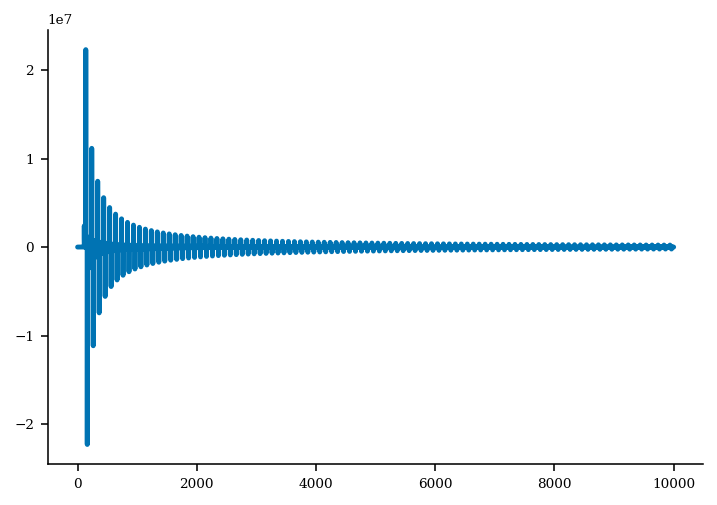

In [169]:
# plt.plot(contravariant_basis['grad_rho'][1])
plt.plot(beta[0])

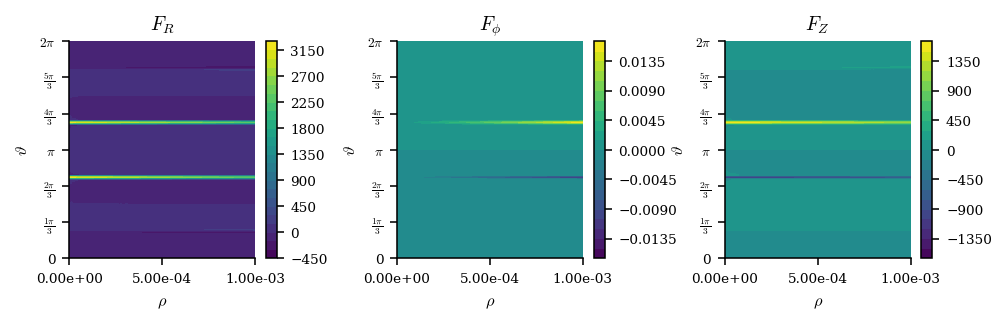

In [157]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots(1,3, figsize=(8,2))

im0 = ax[0].tricontourf(nodes[0],nodes[1],F_err[0], levels=30)
ax[0].set_title('$F_R$')
ax[0].set_xlabel('$\\rho$')
ax[0].set_ylabel('$\\vartheta$')
ax[0].set_xticks(np.linspace(0,1e-3,3))
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax[0].set_yticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[0].set_yticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])
fig.colorbar(im0, ax=ax[0], orientation='vertical',fraction=.1)

im1 = ax[1].tricontourf(nodes[0],nodes[1],F_err[1], levels=30)
ax[1].set_title('$F_\\phi$')
ax[1].set_xlabel('$\\rho$')
ax[1].set_ylabel('$\\vartheta$')
ax[1].set_xticks(np.linspace(0,1e-3,3))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax[1].set_yticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[1].set_yticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])
fig.colorbar(im1, ax=ax[1], orientation='vertical',fraction=.1)

im2 = ax[2].tricontourf(nodes[0],nodes[1],F_err[2], levels=30)
ax[2].set_title('$F_Z$')
ax[2].set_xlabel('$\\rho$')
ax[2].set_ylabel('$\\vartheta$')
ax[2].set_xticks(np.linspace(0,1e-3,3))
ax[2].xaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax[2].set_yticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[2].set_yticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])
fig.colorbar(im2, ax=ax[2], orientation='vertical',fraction=.1)
# plt.axis('equal')
# plt.colorbar()
plt.subplots_adjust(wspace=.5)

[Text(0, 0, '0'),
 Text(0, 0, '$\\frac{1\\pi}{3}$'),
 Text(0, 0, '$\\frac{2\\pi}{3}$'),
 Text(0, 0, '$\\pi$'),
 Text(0, 0, '$\\frac{4\\pi}{3}$'),
 Text(0, 0, '$\\frac{5\\pi}{3}$'),
 Text(0, 0, '$2\\pi$')]

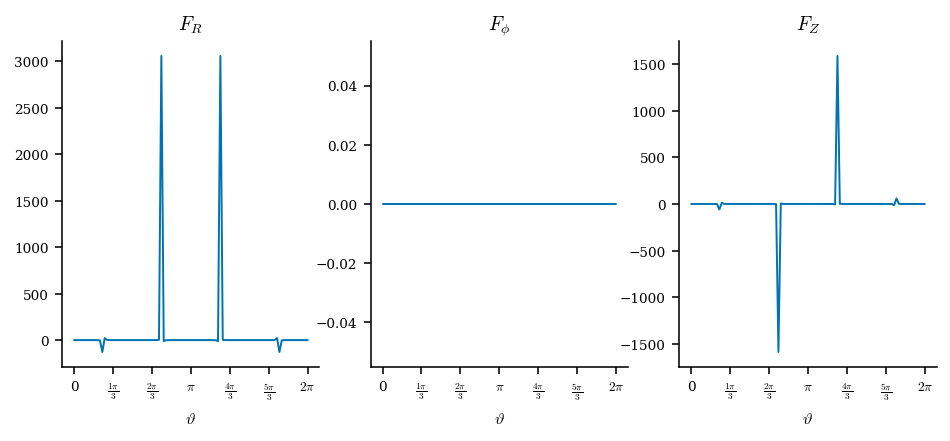

In [164]:
axn = np.where(nodes[0]==0)[0]
fig, ax = plt.subplots(1,3, figsize=(8,3))

ax[0].plot(nodes[1,axn],F_err[0,axn],lw=1)
ax[0].set_title('$F_R$')
ax[0].set_xlabel('$\\vartheta$')
ax[0].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[0].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[1].plot(nodes[1,axn],F_err[1,axn],lw=1)
ax[1].set_title('$F_\\phi$')
ax[1].set_xlabel('$\\vartheta$')
ax[1].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[1].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])

ax[2].plot(nodes[1,axn],F_err[2,axn],lw=1)
ax[2].set_title('$F_Z$')
ax[2].set_xlabel('$\\vartheta$')
ax[2].set_xticks([0,1/3*np.pi, 2/3*np.pi, 3/3*np.pi,4/3*np.pi, 5/3*np.pi, 6/3*np.pi])
ax[2].set_xticklabels(['0','$\\frac{1\\pi}{3}$','$\\frac{2\\pi}{3}$','$\\pi$','$\\frac{4\\pi}{3}$','$\\frac{5\\pi}{3}$','$2\\pi$'])


In [15]:
def plotter(cR,cZ,M,N,NFP,nr=20,ntheta=30,ax=None):
    """Plots solutions (currently only zeta=0 plane)

    Args:
        cR (array-like): spectral coefficients of R
        cZ (array-like): spectral coefficients of Z
        M (int): maximum poloidal mode number
        N (int): maximum toroidal mode number
        NFP (int): number of field periods
        nr (int): number of flux surfaces to show
        ntheta (int): number of theta lines to show
        ax (matplotlib.axes): axes to plot on. If None, a new figure is created.
    
    Returns:
        ax (matplotlib.axes): handle to axes used for the plot
    """

    Nr = 100
    Ntheta = 100
    rstep = Nr//nr
    thetastep = Ntheta//ntheta
    r = np.linspace(0,1,Nr)
    theta = np.linspace(0,2*np.pi,Ntheta)
    rr,tt = np.meshgrid(r,theta,indexing='ij')
    rr = rr.flatten()
    tt = tt.flatten()
    zz = np.zeros_like(rr)
    zernt = ZernikeTransform([rr,tt,zz],M,N,NFP)

    R = zernt.transform(cR).reshape((Nr,Ntheta))
    Z = zernt.transform(cZ).reshape((Nr,Ntheta))

    foo = ax if ax else plt
    # plot desired bdry
    foo.plot(bdryR,bdryZ,color=colorblind_colors[1])
    # plot r contours
    foo.plot(R.T[:,::rstep],Z.T[:,::rstep],color=colorblind_colors[0],lw=.5)
    # plot actual bdry
    foo.plot(R.T[:,-1],Z.T[:,-1],color=colorblind_colors[0],lw=.5)
    # plot theta contours
    foo.plot(R[:,::thetastep],Z[:,::thetastep],color=colorblind_colors[0],lw=.5,ls='--');
    foo.axis('equal')

    return plt.gca()

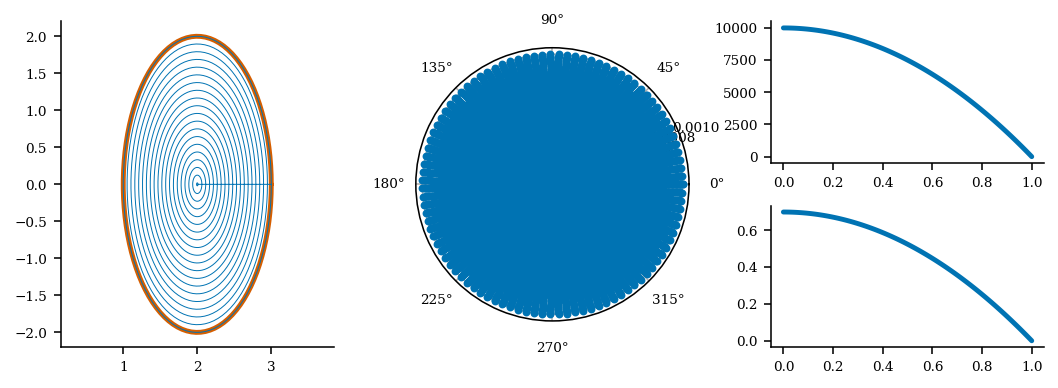

In [185]:

# Inputs
Psi_total = 1
M = 6
N = 0
NFP = 1

# Node locations
N_nodes = 100
r = np.linspace(0,1e-3,100)
dr = np.diff(r)[0]
v = np.linspace(0,2*np.pi,100)
dv = np.diff(v)[0]
dz = 2*np.pi/NFP
rr,vv = np.meshgrid(r,v,indexing='ij')
rr = rr.flatten()
vv = vv.flatten()
zz = np.zeros_like(rr)
nodes = np.stack([rr,vv,zz])
dr = dr*np.ones_like(rr)
dv = dv*np.ones_like(vv)
dz = dz*np.ones_like(zz)

# interpolator
zernt = ZernikeTransform(nodes,M,N,NFP)

# Boundary Shape
bdry_theta = np.linspace(0,2*np.pi,100)
bdry_phi = np.zeros_like(bdry_theta)
b = 1
a = 2
e = np.sqrt(1-b**2/a**2)
R0 = 2
Z0 = 0
bdryR = R0 + b*np.cos(bdry_theta)
bdryZ = Z0 + a*np.sin(bdry_theta)

# initial guess
cR_init,cZ_init,cL_init, Rinit, Zinit = get_initial_guess_scale_bdry(bdryR,bdryZ,bdry_theta,bdry_phi,M,N,NFP)
x_init = np.concatenate([cR_init,cZ_init,cL_init])

# weights
weightF = 1
weightR = 1e3
weightZ = 1e3
weightL = 1e6

# plot IC
fig = plt.figure(figsize=(9,3))
gs = matplotlib.gridspec.GridSpec(2, 3) 
ax0 = plt.subplot(gs[:,0])
ax1 = plt.subplot(gs[:,1],projection='polar')
ax2 = plt.subplot(gs[0,2])
ax3 = plt.subplot(gs[1,2])

ax0.plot(bdryR,bdryZ,color=colorblind_colors[1])
ax0.plot(Rinit,Zinit,lw=.5)
ax0.axis('equal');
ax1.plot(nodes[1],nodes[0],'o',markersize=3);
xx = np.linspace(0,1,100)
ax2.plot(xx,pressfun(xx))
ax3.plot(xx,iotafun(xx))
plt.subplots_adjust(wspace=0.3, hspace=0.3)


In [86]:
def wrapper(x,callback=False, convergence=None, **kwargs):
    nRZ = (M+1)**2*(2*N+1)
    nL = (2*M+1)*(2*N+1)
    cR = x[:nRZ]
    cZ = x[nRZ:2*nRZ]
    cL = x[2*nRZ:]
    
    errF = force_error(cR,cZ,zernt,nodes,pressfun,iotafun,Psi_total,dr,dv,dz)
    errR,errZ,errL = bc_err(cR,cZ,cL,bdryR,bdryZ,bdry_theta,bdry_phi,M,N,NFP)
    errFrms = rms(errF)
    errRrms = rms(errR)
    errZrms = rms(errZ)    
    errLrms = rms(errL)
    
    loss = np.concatenate([weightF*errF.flatten(),weightR*errR.flatten(),weightZ*errZ.flatten(),weightL*errL.flatten()])
    lossrms = rms(loss)
    if callback:
        print('Loss: {:10.3e}  errF: {:10.3e}  errR: {:10.3e}  errZ: {:10.3e}  errL: {:10.3e}'.format(
        lossrms,errFrms,errRrms,errZrms,errLrms),end='')
        if convergence is not None:
            print('  Convg: {}'.format(convergence),end='')
        print('')
    
    else:
        return loss

def jac(x0,fun,rel_step=np.finfo(np.float64).eps**(1/3)):
    f0 = fun(x0)
    m = f0.size
    n = x0.size
    J_transposed = np.empty((n, m))
    sign_x0 = (x0 >= 0).astype(float) * 2 - 1
    h = rel_step * sign_x0 * np.maximum(1.0, np.abs(x0))
    h_vecs = np.diag(h)
    for i in range(h.size):
        x1 = x0 - h_vecs[i]
        x2 = x0 + h_vecs[i]
        dx = x2[i] - x1[i]
        f1 = fun(x1)
        f2 = fun(x2)
        df = f2 - f1
        J_transposed[i] = df / dx

    if m == 1:
        J_transposed = np.ravel(J_transposed)

    return J_transposed.T

def callback(x,f=None,convergence=None):
    
    wrapper(x,callback=True,convergence=convergence)

In [87]:
callback(x_init)
out = scipy.optimize.least_squares(wrapper,x_init,x_scale='jac',ftol=1e-4, xtol=1e-4, gtol=1e-4, max_nfev=100, verbose=1)

Loss:  1.030e-01  errF:  1.331e-01  errR:  4.026e-07  errZ:  2.312e-15  errL:  0.000e+00
The maximum number of function evaluations is exceeded.
Function evaluations 100, initial cost 2.6562e+00, final cost 3.8657e-04, first-order optimality 2.28e+01.


In [88]:
callback(x_init)
callback(out['x'])

Loss:  1.030e-01  errF:  1.331e-01  errR:  4.026e-07  errZ:  2.312e-15  errL:  0.000e+00
Loss:  1.242e-03  errF:  1.566e-03  errR:  4.412e-07  errZ:  4.292e-07  errL:  1.236e-18


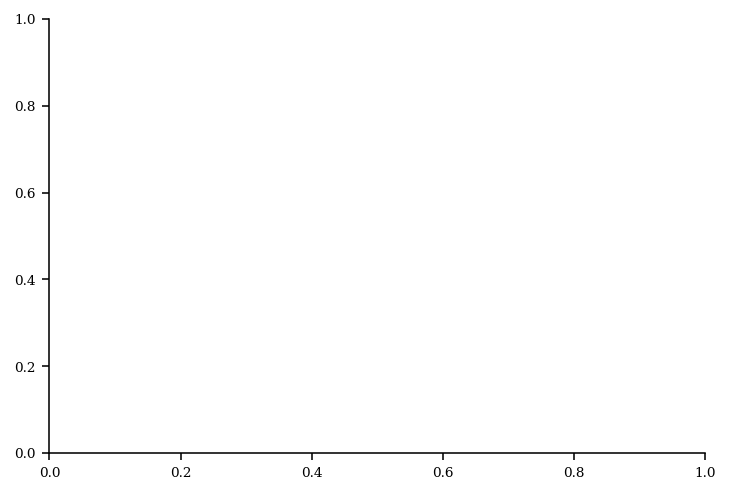

In [104]:
plt.gca()

In [81]:
callback(x_init)
out = scipy.optimize.minimize(wrapper,
                              x_init,
                              method='SLSQP',
                              jac=jac,
                              options={'disp':True},
                              constraints=[{'type':'eq','fun':lambda_constraint,'jac':lambda x: jac(x,fun=lambda_constraint)},
                                           {'type':'ineq','fun':bc_constraint,'jac':lambda x: jac(x,fun=bc_constraint)}],
                              callback=callback)

Loss:  1.784e-01  errF:  1.780e-01  errR:  4.026e-07  errZ:  1.028e-14  errL:  0.000e+00
Loss:  1.784e-01  errF:  1.780e-01  errR:  4.026e-07  errZ:  1.028e-14  errL:  0.000e+00
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 0.17842005718931178
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1


In [ ]:
callback(x_init)
bounds = np.stack([-100*np.ones_like(x_init),100*np.ones_like(x_init)]).T
out = scipy.optimize.dual_annealing(wrapper,bounds,callback=lambda x,f,t: callback(x))

In [57]:
callback(x_init)
bounds = np.stack([-20*np.ones_like(x_init),20*np.ones_like(x_init)]).T
init_pop = (x_init*(np.random.normal(loc=1,scale=.1,size=(1000,x_init.size))))
out = scipy.optimize.differential_evolution(wrapper,bounds,init=init_pop,callback=callback)

Loss:  1.788e+01  errF:  1.787e+01  errR:  4.026e-07  errZ:  1.028e-14  errL:  0.000e+00
Loss:  6.450e+01  errF:  1.978e+01  errR:  1.561e-02  errZ:  2.911e-02  errL:  0.000e+00  Convg: 0.023805956103090414
Loss:  6.450e+01  errF:  1.978e+01  errR:  1.561e-02  errZ:  2.911e-02  errL:  0.000e+00  Convg: 0.025043346349493855
Loss:  4.149e+01  errF:  1.862e+01  errR:  9.764e-03  errZ:  1.311e-02  errL:  0.000e+00  Convg: 0.024265511666393166
Loss:  3.008e+01  errF:  1.799e+01  errR:  4.189e-03  errZ:  7.905e-03  errL:  0.000e+00  Convg: 0.02527683567597544
Loss:  2.810e+01  errF:  1.794e+01  errR:  3.078e-03  errZ:  7.081e-03  errL:  0.000e+00  Convg: 0.02322363114199262
Loss:  2.810e+01  errF:  1.794e+01  errR:  3.078e-03  errZ:  7.081e-03  errL:  0.000e+00  Convg: 0.024046078116936005
Loss:  2.810e+01  errF:  1.796e+01  errR:  3.063e-03  errZ:  7.081e-03  errL:  0.000e+00  Convg: 0.023628953779158
Loss:  2.810e+01  errF:  1.796e+01  errR:  3.063e-03  errZ:  7.081e-03  errL:  0.000e+00  

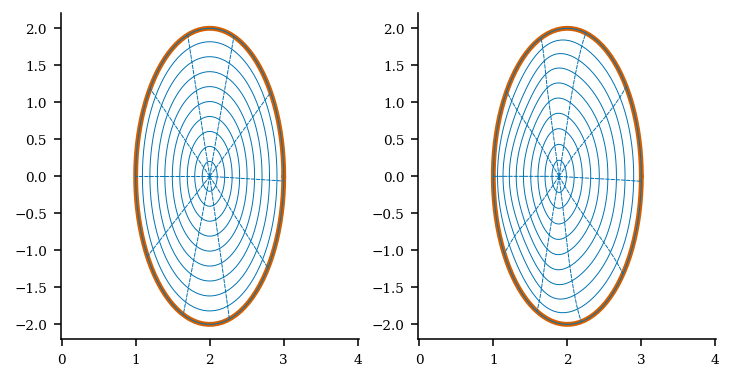

In [89]:
x = out['x']
# x = init_pop[1]
nRZ = (M+1)**2*(2*N+1)
nL = (2*M+1)*(2*N+1)
cR = x[:nRZ]
cZ = x[nRZ:2*nRZ]
cL = x[2*nRZ:]

fig, ax = plt.subplots(1,2,figsize=(6,3))
plotter(cR_init,cZ_init,M,N,NFP,ax=ax[0],nr=10,ntheta=10)
plotter(cR,cZ,M,N,NFP,ax=ax[1],nr=10,ntheta=10)

In [105]:
ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d91a08e10>,
      dtype=object)

In [93]:
def DESC_to_gfile(cR,cZ,iotafun,pressfun,Psi_total,M,N,NFP,nw=65,nh=65,nr=50,ntheta=50,npsi=1000, 
                  rdim=None,zdim=None,rleft=None,rcentr=None,zmid=None,axis_flux=0):

    g = {}
    g['date']=pytime.localtime()
    g['shot']=0
    g['time']=0
    g['efit']='DESC'
    g['nw']=nw
    g['nh']=nh


    # get poloidal flux (psi) as function of toroidal flux (rho)
    efitPsi = np.linspace(0,1,g['nw'])
    rho_n = np.linspace(1e-3,1,npsi)
    rho = 2*Psi_total*rho_n
    iota = iotafun(rho_n)
    psi = scipy.integrate.cumtrapz(rho*iota,rho_n,initial=axis_flux)
    psi_n = (psi - np.min(psi))/(np.max(psi)-np.min(psi))
    psi_n_of_rho_n = scipy.interpolate.CubicSpline(rho_n,psi_n)
    psi_of_rho_n = scipy.interpolate.CubicSpline(rho_n,psi)
    rho_n_of_psi_n = scipy.interpolate.CubicSpline(psi_n,rho_n)

    # get Bt
    vv = np.zeros_like(rho_n)
    zz = np.zeros_like(rho_n)
    nodes = np.stack([rho_n,vv,zz])
    zernt = ZernikeTransform(nodes,M,N,NFP)
    coordinate_derivatives = compute_coordinate_derivatives(cR,cZ,zernt)
    covariant_basis_vectors = compute_covariant_basis_vectors(coordinate_derivatives)
    jacobian = compute_jacobian(coordinate_derivatives,covariant_basis_vectors)
    B_field = compute_B_field(Psi_total, jacobian, nodes, covariant_basis_vectors, iotafun)
    R = zernt.transform(cR).flatten()
    B = B_field['B^theta']*covariant_basis_vectors['e_v'] + B_field['B^zeta']*covariant_basis_vectors['e_z']
    Bt = B[1]
    g['bcentr'] = np.linalg.norm(B[:,0])

    # compute profiles
    Fpol = scipy.interpolate.CubicSpline(rho_n,R*Bt)
    g['fpol'] = Fpol(rho_n_of_psi_n(efitPsi))
    g['ffprime'] = Fpol(rho_n_of_psi_n(efitPsi))*Fpol(rho_n_of_psi_n(efitPsi),nu=1)*rho_n_of_psi_n(efitPsi,nu=1)
    g['pres'] = pressfun(rho_n_of_psi_n(efitPsi))
    g['pprime'] = pressfun(rho_n_of_psi_n(efitPsi),nu=1)*rho_n_of_psi_n(efitPsi,nu=1)
    iotapsi = iotafun(rho_n_of_psi_n(efitPsi))
    qidx = np.where(iotapsi != 0)[0]
    g['qpsi'] = scipy.interpolate.CubicSpline(efitPsi[qidx],1/iotapsi[qidx])(efitPsi)


    # compute psi(R,Z)
    r = np.linspace(0,1,nr)
    v = np.linspace(0,2*np.pi,ntheta)
    rr,vv = np.meshgrid(r,v,indexing='ij')
    rr = rr.flatten()
    vv = vv.flatten()
    zz = np.zeros_like(rr)
    nodes = np.stack([rr,vv,zz])
    axn = np.where(rr==0)[0]
    bdryn = np.where(rr==1)[0]
    zernt = ZernikeTransform(nodes,M,N,NFP)

    R = zernt.transform(cR).flatten()
    Z = zernt.transform(cZ).flatten()
    psiRZ = psi_of_rho_n(rr)

    g['rmaxis'] = np.mean(R[axn])
    g['zmaxis'] = np.mean(Z[axn])
    g['nbbbs'] = bdryn.size
    g['rbbbs'] = R[bdryn]
    g['zbbbs'] = Z[bdryn]
    g['axis_flux'] = np.mean(psiRZ[axn])
    g['boundary_flux'] = np.mean(psiRZ[bdryn])

    g['rdim'] = rdim if rdim else (np.max(R)-np.min(R))*1.5
    g['rcentr'] = rcentr if rcentr else (np.max(R)+np.min(R))/2
    g['zdim'] = zdim if zdim else (np.max(Z)-np.min(Z))*1.5
    g['zmid'] = zmid if zmid else (np.max(Z)+np.min(Z))/2
    g['rleft'] = rleft if rleft else g['rcentr'] - g['rdim']/2

    efitR = np.linspace(g['rleft'],g['rleft']+g['rdim'],g['nw'])
    efitZ = np.linspace(-g['zdim']/2,g['zdim']/2,g['nh'])
    efitRR,efitZZ = np.meshgrid(efitR,efitZ,indexing='ij')

    g['psirz'] = scipy.interpolate.griddata((R,Z),psiRZ,(efitRR,efitZZ),method='cubic').T
    g['psirz'][np.isnan(g['psirz'])] = g['boundary_flux']

    g['limitr'] = 0
    g['rlimitr'] = np.array([])
    g['zlimitr'] = np.array([])
    
    return g

(<Figure size 1128x846 with 7 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d90c86ac8>,
       dtype=object))

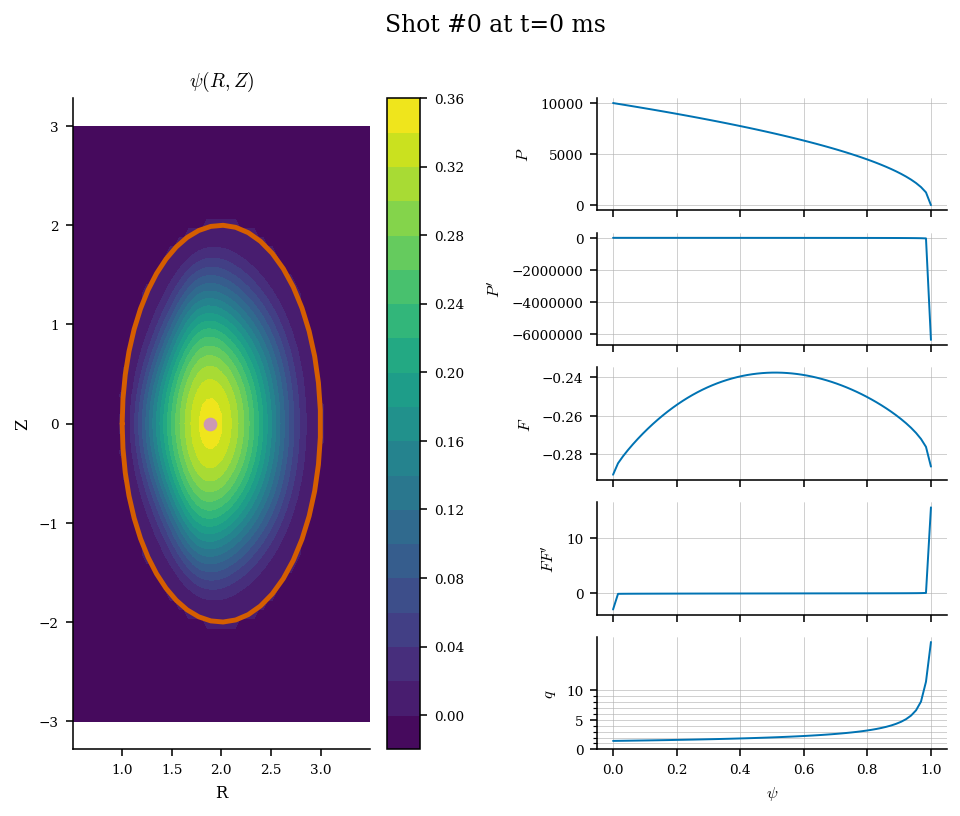

In [92]:
plot_gfile(DESC_to_gfile(cR,cZ,iotafun,pressfun,Psi_total,M,N,NFP))

In [43]:
covariant_basis_vectors['e_v'].shape

(3, 1000, 1)

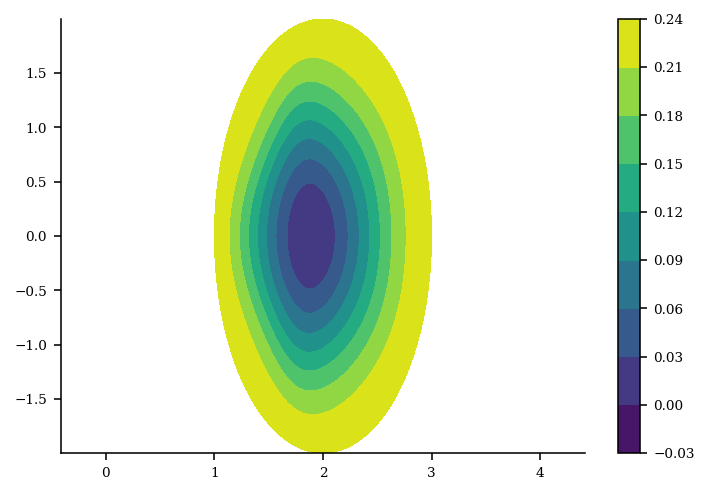

In [37]:
plt.tricontourf(R,Z,psiRZ)
plt.axis('equal')
plt.colorbar()

In [197]:
axn = np.where(rr==0)[0]

In [198]:
pytime.strftime("%m/%d/%Y",g['date'])

'07/25/2020'

In [199]:
g['date']

time.struct_time(tm_year=2020, tm_mon=7, tm_mday=25, tm_hour=1, tm_min=35, tm_sec=41, tm_wday=5, tm_yday=207, tm_isdst=1)

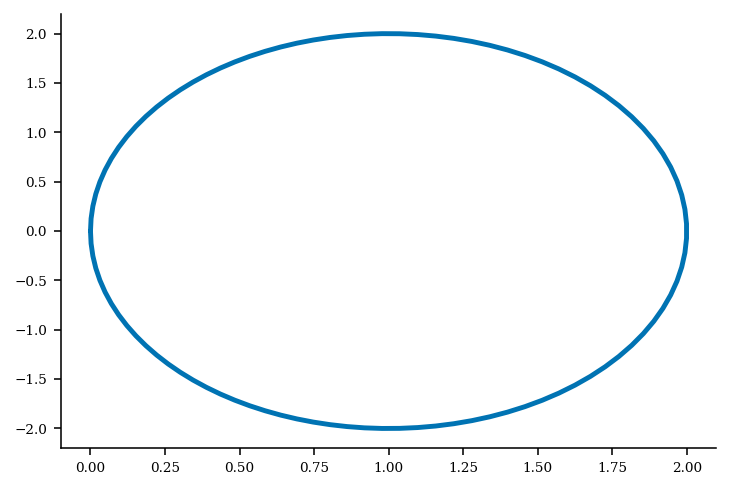

In [186]:
plt.plot(R[bdryn],Z[bdryn])

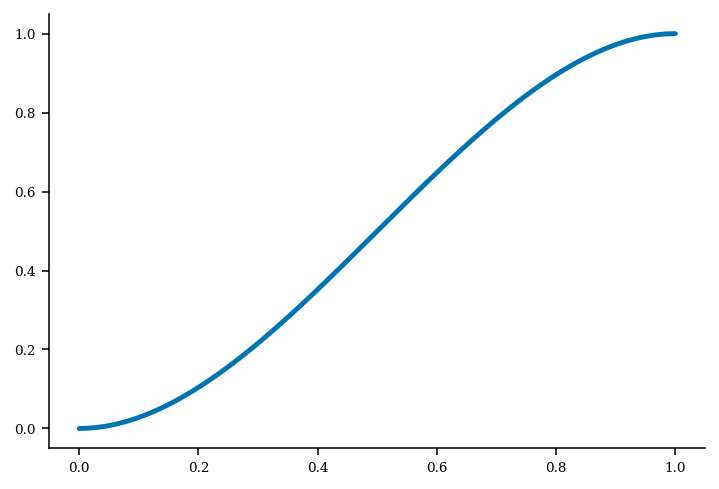

In [170]:
plt.plot(rho_n,psi_n)

In [28]:
logerr = np.sign(F_err)*np.log(np.abs(F_err))
plt.quiver(R,Z,logerr[0],logerr[2],headwidth=3,headlength=5,width=2e-3)
plt.plot(bdryR,bdryZ)
plt.scatter(R,Z,s=3)
plt.axis('equal');

NameError: name 'F_err' is not defined

In [74]:
from sympy import symbols, Matrix, diff, pi

er_R, er_P, er_Z = symbols("R_rho phi_rho Z_rho")
ev_R, ev_P, ev_Z = symbols("R_theta phi_theta Z_theta")
ez_R, ez_P, ez_Z = symbols("R_\zeta R Z_\zeta")
psi_a, rho, iota = symbols("psi_a rho iota")

psi = psi_a*rho**2
e_r = Matrix([er_R,0,er_Z])
e_v = Matrix([ev_R,0,ev_Z])
e_z = Matrix([ez_R,ez_P,ez_Z])

g = e_v.cross(e_z).dot(e_r)

erho = e_v.cross(e_z)/g
etheta = e_z.cross(e_r)
ezeta = e_r.cross(e_v)

Bzeta = diff(psi,rho)/(2*pi*g)
Btheta = iota*Bzeta
B = Btheta*etheta + Bzeta*ezeta


beta = Bzeta*etheta - Btheta*ezeta

In [72]:
erho

Matrix([
[                         -R*Z_theta/(-R*R_rho*Z_theta + R*R_theta*Z_rho)],
[(R_\zeta*Z_theta - R_theta*Z_\zeta)/(-R*R_rho*Z_theta + R*R_theta*Z_rho)],
[                          R*R_theta/(-R*R_rho*Z_theta + R*R_theta*Z_rho)]])

In [73]:
beta

Matrix([
[                                                                                                                      R*Z_rho*psi_a*rho/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))],
[-iota*psi_a*rho*(-R_rho*Z_theta + R_theta*Z_rho)/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho)) + psi_a*rho*(-R_\zeta*Z_rho + R_rho*Z_\zeta)/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))],
[                                                                                                                     -R*R_rho*psi_a*rho/(pi*(-R*R_rho*Z_theta + R*R_theta*Z_rho))]])

$$
\begin{equation}
\begin{pmatrix}
\dot{R} \\ 
\dot{\phi} \\ 
\dot{Z}\\
\end{pmatrix} 
= 
\begin{pmatrix}
\frac{\partial R}{\partial t} \\
\frac{\partial \phi}{\partial R}\frac{\partial R}{\partial t} +  \frac{\partial \phi}{\partial Z}\frac{\partial Z}{\partial t}  \\
\frac{\partial Z}{\partial t} \\
\end{pmatrix}
\end{equation}
$$

$$
\begin{equation}
\begin{pmatrix}
\dot{R} \\ 
\dot{\phi} \\ 
\dot{Z}\\
\end{pmatrix} 
= 
\begin{pmatrix}
1 & 0 \\
\frac{\partial \phi}{\partial R} & \frac{\partial \phi}{\partial Z} \\
0 & 1 \\
\end{pmatrix}
\begin{pmatrix}
\frac{\partial R}{\partial t} \\
\frac{\partial Z}{\partial t} \\
\end{pmatrix}
\end{equation}
$$

$$
\vartheta = \pi - \theta + \lambda(\theta,\phi)
$$